In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "RMSE"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'RandomForestRegressor', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor', 'GPBoost_RMSE'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_RMSE': 'GP'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

df = df[df["metric"] == "RMSE"]
df = df[df["split_method"] == "random_split"]

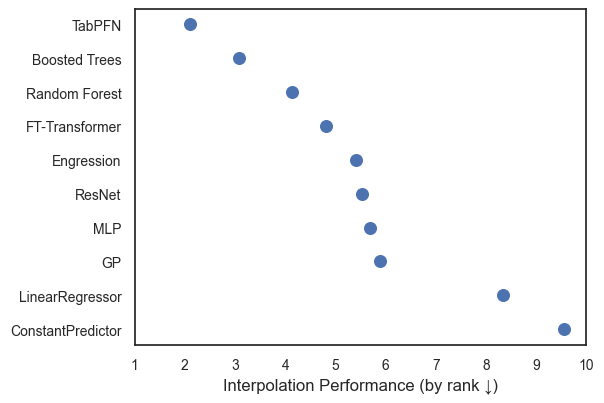

In [3]:
sns.set_theme(style="white", rc={"axes.grid": False})   


plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),   # taller than 12x6
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor', 'LinearRegressor'
    , 'RandomForestRegressor', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor', 'GPBoost_RMSE'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestRegressor':'Random Forest',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'TabPFNRegressor':      'TabPFN',
    'GPBoost_RMSE':        'GP'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

order = overall.sort_values('Mean')['Method']
y = overall.set_index('Method').loc[order]['Mean']

fig, ax = plt.subplots()
ax.scatter(y.values, range(len(y)), s=70)
ax.set_yticks(range(len(y)))
ax.set_yticklabels(order)           # full names are readable on the y-axis
ax.invert_yaxis()                   # best at top
ax.set_xlabel("Interpolation Performance (by rank ↓)")
ax.set_ylabel("")
ax.set_xlim(1, 10)
plt.tight_layout()
plt.savefig("PICTURES/average_rank_IP_RMSE.pdf", bbox_inches="tight")  # VECTOR
plt.show()
plt.close()


